In [1]:
import gym
import numpy as np
import random
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
map = [
    'SFFFF',
    'FHFHF',
    'HFFHF',
    'HFFFH',
    'FFFFG'
]

In [3]:
env = gym.make('FrozenLake-v0', is_slippery=False, desc = map)


# visualize 4x4 frozen lake
env.render()


SFFFF
FHFHF
HFFHF
HFFFH
FFFFG


In [4]:
# Total number of States and Actions
n_states = env.observation_space.n
n_actions = env.action_space.n
n_rows = 5
n_cols = 5


In [43]:
def restrict_actions(Q, n_states, n_rows):

  Q.at[n_states -1, :] = np.zeros(n_actions,)
  for i in range( 0, n_states, n_rows): 
    Q.at[i,0] = np.NaN
  for i in range( n_rows -1 , n_states, n_rows): 
    Q.at[i,2] = np.NaN
  for i in range(0, n_rows):
    Q.at[i,3] = np.NaN
  for i in range(n_states - n_rows , n_states):
    Q.at[i,1 ]= np.NaN
  
  return Q
  

In [50]:
def rewarder(new_state, reward):
  if map[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'H':
    reward -= 20
  elif map[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'F':
    reward -= 1 
  elif map[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'S':
    reward -= 1
  else: #goal
    reward += 100

  return reward

In [7]:
def choose_action(Q, state, epsilon):
  random_for_epsilon = np.random.rand()
  if random_for_epsilon <= epsilon:
    s = Q.loc[state].notna()
    vals = s[s].index.values
    action = random.choice(vals)
  else: 
    Q.loc[state] += np.random.rand(n_actions,)/100
    action = np.argmax(Q.loc[state])
  return action

In [8]:
##assign index to each state using state-matrix

state_matrix = np.arange(0,n_states).reshape(n_rows,n_cols)
state_matrix

def rowsandcols(state):
  ''' input: state returned by env
      output: location of state as (row,col) tuple'''
  return int(np.where(state_matrix ==state)[0]), int(np.where(state_matrix ==state)[1])

In [75]:
Q = pd.read_excel('/content/4x4_to_5x5 (1).xlsx', header = None)

In [76]:
for i in range(n_states -1):
  if (Q.loc[i]==0.0).all():
    Q.loc[i] = np.random.rand(n_actions,)*1/1000



In [77]:
Q= restrict_actions(Q, n_states, n_rows)

In [78]:
Q

,0,1,2,3
0,NaN,28.125687,40.247988,NaN
1,31.533015,-24.774719,47.239076,NaN
2,34.191449,56.482323,30.150683,NaN
3,44.720851,-24.887856,NaN,NaN
4,0.000049,0.000124,NaN,NaN
5,NaN,-21.021211,-21.892915,32.201386
6,0.009872,0.002689,0.008649,0.007160
7,-23.020096,66.289111,-23.113817,36.968893
8,0.005538,0.002576,NaN,0.004187
9,0.000282,0.000533,NaN,0.000115


In [79]:
epsilon = 0.8
epsilon_final = 0.1
epsilon_decay = 0.999
gamma = 0.90 # discount factor
learning_rate = 0.9 #how important is the difference between q-val from q-table and what's observed

In [80]:
num_episodes = 1000
steps_total = [] # store number of steps taken in each episode
rewards_total = [] #store reward obtained for each episode
epsilon_total = [] #store epsilon obtained at the end of each episode
terminal_state = []

In [81]:
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0
    reward = 0

  ## as epsilon decays with more timesteps, the prob. of selecting a random val < e decays --> more likely to exploit. 
    if epsilon > epsilon_final:
            epsilon *= epsilon_decay

    while True:
        
        step += 1
        
        random_for_epsilon = np.random.rand()
        if random_for_epsilon <= epsilon:
          action = env.action_space.sample()
        else: 
          action = np.argmax(Q.loc[state])
  
         
        ## env gives reward and next state and whether we've reached terminal state upon taking action at current state.. 
        new_state, _ , done, info = env.step(action)

        ##if you want reward penalized at for each timestep
        reward = rewarder(new_state, reward)

        # filling the Q Table - 
        
        Q.loc[state, action] = (1- learning_rate)*Q.at[state, action] + learning_rate*(reward + gamma * np.max(Q.loc[new_state]))
        
        # Setting new state for next action
        state = new_state
        tile = map[rowsandcols(state)[0]][rowsandcols(state)[1]]
        #env.render()
        
        if done:
          #print(Q)
          
          terminal_state.append(tile)
          steps_total.append(step)
          rewards_total.append(reward)
          epsilon_total.append(epsilon)
          if i_episode % 10 == 0:
            print('Episode: {} Reward: {} Steps Taken: {} Terminal State: {}, Epsilon: {}'.format(i_episode,reward, step, tile, epsilon))
          break


Episode: 0 Reward: -28 Steps Taken: 9 Terminal State: H, Epsilon: 0.7992
Episode: 10 Reward: -21 Steps Taken: 2 Terminal State: H, Epsilon: 0.7912438682636309
Episode: 20 Reward: -27 Steps Taken: 8 Terminal State: H, Epsilon: 0.7833669407717642
Episode: 30 Reward: -22 Steps Taken: 3 Terminal State: H, Epsilon: 0.7755684290366581
Episode: 40 Reward: -22 Steps Taken: 3 Terminal State: H, Epsilon: 0.7678475524200608
Episode: 50 Reward: -21 Steps Taken: 2 Terminal State: H, Epsilon: 0.7602035380550674
Episode: 60 Reward: -31 Steps Taken: 12 Terminal State: H, Epsilon: 0.7526356207687559
Episode: 70 Reward: -23 Steps Taken: 4 Terminal State: H, Epsilon: 0.7451430430055925
Episode: 80 Reward: -27 Steps Taken: 8 Terminal State: H, Epsilon: 0.7377250547515992
Episode: 90 Reward: -21 Steps Taken: 2 Terminal State: H, Epsilon: 0.7303809134592769
Episode: 100 Reward: -24 Steps Taken: 5 Terminal State: H, Epsilon: 0.7231098839732764
Episode: 110 Reward: -21 Steps Taken: 2 Terminal State: H, Epsilo

In [82]:
%matplotlib inline

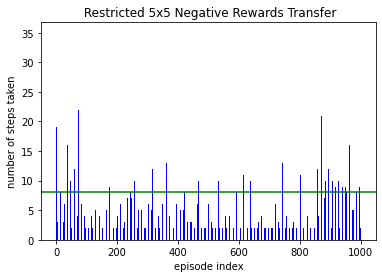

In [86]:
plt.axhline(y=8, color='green', linestyle='-')
plt.bar(np.arange(0, 1000), steps_total, 
        width = 0.4, color = 'blue')
plt.xlabel('episode index')
plt.ylabel('number of steps taken')
plt.title(' Restricted 5x5 Negative Rewards Transfer')
plt.show()

Text(0, 0.5, 'reward')

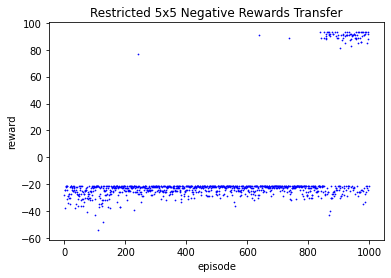

In [85]:
plt.scatter(np.arange(0, 1000), rewards_total, s = 0.5, color = 'blue')
plt.title('Restricted 5x5 Negative Rewards Transfer')
plt.xlabel('episode')
plt.ylabel('reward')